In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats

pd.set_option('display.max_rows', 100)
pd.set_option("display.max_columns", 100)

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

## 【問題1】コンペティション内容の確認
コンペティションのOverviewページ読み、「Home Credit Default Risk」について以下の観点について確認してください。

* 何を学習し、何を予測するのか
* どのようなファイルを作りKaggleに提出するか
* 提出されたものはどういった指標値で評価されるのか

* 何を学習し、何を予測するのか  
過去の取引情報と信用調査会社の情報から、クライアントの真の返済能力を予測する


* どのようなファイルを作りKaggleに提出するか  
↓の通り


* 提出されたものはどういった指標値で評価されるのか  
予測された確率と観測されたターゲット間のROC曲線の領域で評価される


In [4]:
train = pd.read_csv("application_train.csv")
test = pd.read_csv("application_test.csv")
sample = pd.read_csv("sample_submission.csv")
sample.head()

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5
3,100028,0.5
4,100038,0.5


## 【問題2】学習と検証
データを簡単に分析、前処理し、学習、検証するまでの一連の流れを作成・実行してください。

検証にはこのコンペティションで使用される評価指標を用いるようにしてください。学習に用いる手法は指定しません。

### 欠損処理

In [5]:
#欠損テーブルを作成する関数
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [6]:
train_na_cols = missing_data(train).query("Total > 0").index
test_na_cols = missing_data(test).query("Total > 0").index

missing_cols = set(train_na_cols | test_na_cols)

In [7]:
train = train.drop(columns=missing_cols)
test = test.drop(columns=missing_cols)

### カテゴリ変数の数値化

In [8]:
from sklearn.preprocessing import LabelEncoder

categorical_feats = train.dtypes[train.dtypes == "object"].index

for cols in categorical_feats:
    le = LabelEncoder()
    train[cols] = le.fit_transform(train[cols])
    test[cols] = le.fit_transform(test[cols])

In [9]:
X = train.drop("TARGET", axis=1)
y = train["TARGET"]

特徴量が多いと学習が終わらないので絞る

In [10]:
attention_feats = ["CODE_GENDER", "AMT_INCOME_TOTAL", "ORGANIZATION_TYPE"]
X = train[attention_feats]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [12]:
rfc = RandomForestClassifier().fit(X_train, y_train)
pred_rfc = rfc.predict(X_test)

### 推定と評価

In [13]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score

print(confusion_matrix(y_test, pred_rfc))
print(accuracy_score(y_test, pred_rfc))
print(precision_score(y_test, pred_rfc))
print(recall_score(y_test, pred_rfc))
print(f1_score(y_test, pred_rfc))

[[84750   164]
 [ 7318    22]]
0.918897825568539
0.11827956989247312
0.002997275204359673
0.005846399149614669


### ROC曲線を描く

0.500532954675925


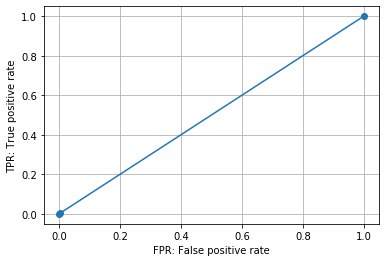

In [14]:
fpr, tpr, thresholds = roc_curve(y_test, pred_rfc)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

print(roc_auc_score(y_test, pred_rfc))

## 【問題3】テストデータに対する推定

In [15]:
test = test[attention_feats]

In [16]:
pred = rfc.predict_proba(test)
sample["TARGET"] = pred[:, 1]

In [17]:
sample.to_csv("submit.csv", index=None)

## 【問題4】特徴量エンジニアリング
精度を上げるために以下のような観点で 特徴量エンジニアリング（Feature Engineering） を行ってください。

* どの特徴量を使うか
* どう前処理をするか

何をした時に検証データに対する評価指標がどのようになったかをまとめてください。

最低5パターンの学習・検証を行ってください。

精度が高かったものに関してはテストデータに対しても推定を行い、Kaggleに提出を行ってください

### 共通処理・分析・考察

In [18]:
train = pd.read_csv("application_train.csv")
test = pd.read_csv("application_test.csv")
sample = pd.read_csv("sample_submission.csv")

In [19]:
#学習データを特徴量と目的変数に分ける
train_x = train.drop(["TARGET"], axis=1)
train_y = train["TARGET"]
#テストデータは特徴量のみなので、そのままでいい
test_x = test.copy()

#SK_ID_CURRは除外する
train_x = train_x.drop(["SK_ID_CURR"], axis=1)
test_x  = test_x.drop(["SK_ID_CURR"], axis=1)

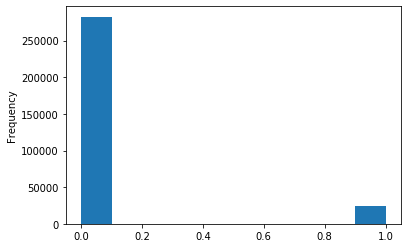

In [20]:
#ターゲットの分布を確認
train_y.plot.hist()
plt.show()

ターゲットの分布に偏りがあることが判明  
ほとんどが返済能力ありと分類されていることが分かる

In [21]:
#欠損を確認する
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [22]:
missing_data(train_x).query("Total > 0")

,Total,Percent
COMMONAREA_MEDI,214865,69.872297
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
NONLIVINGAPARTMENTS_AVG,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953


かなり欠損列が多い。その扱いについてはひとつひとつ確認する必要がありそう

In [23]:
#カテゴリ変数の確認
train_x.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

カテゴリカル変数は１６個存在する。  
機械学習が行える形への何らかな変換処理が必要

In [24]:
train_x.describe()

,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,...,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,104582.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307509.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,134133.000000,3.068510e+05,246546.000000,151450.00000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,...,97312.000000,153161.000000,93997.000000,137829.000000,151450.000000,127568.000000,157504.000000,103023.000000,92646.000000,143620.000000,152683.000000,154491.000000,98869.000000,124921.000000,97312.000000,153161.000000,93997.000000,137829.000000,159080.000000,306490.000000,306490.000000,306490.000000,306490.000000,307510.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.00000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,-4986.120328,-2994.202373,12.061091,0.999997,0.819889,0.199368,0.998133,0.281066,0.056720,2.152665,2.052463,2.031521,12.063419,0.015144,0.050769,0.040659,0.078173,0.230454,0.179555,0.502130,5.143927e-01,0.510853,0.11744,0.088442,0.977735,0.752471,0.044621,0.078942,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399,0.008809,0.028358,0.114231,0.087543,0.977065,0.759637,0.042553,0.074490,...,0.105645,0.105975,0.008076,0.027022,0.117850,0.087955,0.977752,0.755746,0.044595,0.078078,0.149213,0.225897,0.231625,0.067169,0.101954,0.108607,0.008651,0.028236,0.102547,1.422245,0.143421,1.405292,0.100049,-962.858788,0.000042,0.710023,0.000081,0.015115,0.088055,0

気になったこと  
* CNT_CHILDREN：マックスで１９人子供がいる人がいる。ほとんどの家庭は１人
* DAYS_XXX：値がマイナスになっているのはなぜ？
* DAYS_EMPLOYED：最大値がプラスのものがある。
* CNT_FAM_MEMBERS：２０人家族がいる。家族構成が不明な人を２０と値づけしてないか疑う

試したいこと  
* 収入に対する年金の割合を特徴量として作成
* 収入に対するローン借入額を特徴量として作成

In [25]:
attention_cols = ["CNT_CHILDREN", "DAYS_BIRTH"]

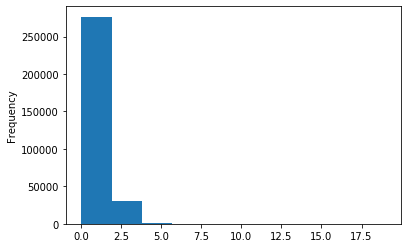

In [26]:
# 子供の数を確認
train_x["CNT_CHILDREN"].plot.hist()
plt.show()

19人のひとは単なる外れ値（珍しい人）で不明等の意味を表すものではなかった

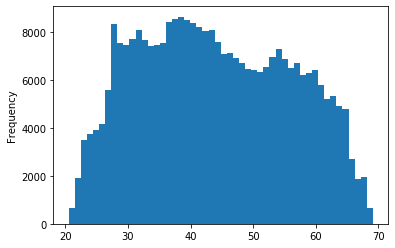

In [27]:
# 申込日時点ので日齢を確認
(train_x["DAYS_BIRTH"] / -365).plot.hist(bins=50)
plt.show()

20歳～70歳がこのデータセットには含まれるということが分かる  
マイナス値なのは特に意味はなさそう

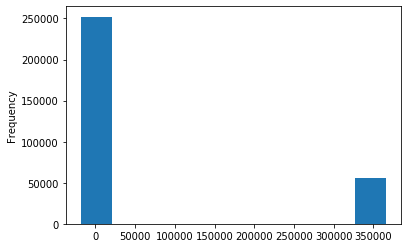

In [28]:
train_x["DAYS_EMPLOYED"].plot.hist()
plt.show()

In [29]:
print(train_x["OCCUPATION_TYPE"].unique())
train_x[train_x["DAYS_EMPLOYED"] == 365243][["DAYS_EMPLOYED","OCCUPATION_TYPE"]]

['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medicine staff' 'Security staff' 'High skill tech staff'
 'Waiters/barmen staff' 'Low-skill Laborers' 'Realty agents' 'Secretaries'
 'IT staff' 'HR staff']


,DAYS_EMPLOYED,OCCUPATION_TYPE
8,365243,NaN
11,365243,NaN
23,365243,NaN
38,365243,NaN
43,365243,NaN
...,...,...
307469,365243,NaN
307483,365243,NaN
307487,365243,NaN
307505,365243,NaN


雇用期間が365523になっている人は無職 or 不明な人  
365523は意味合いとしては実質０なので欠損値を代入すると性能はあがるかも

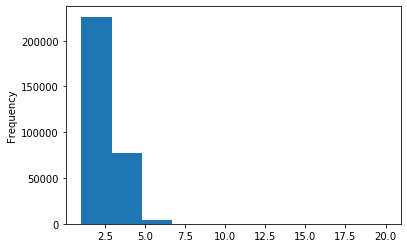

In [30]:
train_x["CNT_FAM_MEMBERS"].plot.hist()
plt.show()

子供の分布と似ていて期待通り。外れ値もただ単に珍しいだけ

### 方針

以上の分析・考察より、以下のパターンで前処理・特徴量選択を進めモデル精度を検証する。  
なお、今回使用するモデルは**light-GBM**をつかう（欠損をそのまま扱えるため）

1. 欠損のある列をすべて削除し、残りの全ての特徴量を用いて学習・推定を行う  
2. 欠損列を残したまま全ての特徴量を用いて学習・推定を行う
3. 2.のモデルで算出された重要度の高い上位20個の特徴で学習・推定を行う
4. 既存の特徴量を加工して学習・推定を行う（DAYS_EMPLOYEDの加工）
5. 新しい特徴量を追加して学習・推定を行う

予想としては5＞4＞3＞2＞1 の順番でスコアが高くなると思う

### 実践

#### 欠損のある列をすべて削除し、残りの全ての特徴量を用いて学習・推定を行う

In [31]:
#まずは事前処理したデータセットをコピー
train_x1 = train_x.copy()
train_y1 = train_y.copy()
test_x1 = test_x.copy()

#訓練データとテストデータどちらも欠損列を削除
train_x1.dropna(axis=1, inplace=True)
test_x1.dropna(axis=1, inplace=True)

#行列の数を確認
print(train_x1.shape)
print(test_x1.shape)

(307511, 53)
(48744, 56)


In [32]:
#列数を少ない方にあわせる
train_x1, test_x1 = train_x1.align(test_x1, join="inner", axis=1)

#行列の数を確認
print(train_x1.shape)
print(test_x1.shape)

(307511, 53)
(48744, 53)


In [33]:
#フィーチャー数が２つのものはラベルエンコーダー、3つ以上はワンホットエンコーダー
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le_count = 0

for col in train_x1:
    if train_x1[col].dtype == 'object':
        # フィーチャー数が２以上のものはラベルエンコーディング
        if len(list(train_x1[col].unique())) <= 2:
            # 訓練データをつかって学習
            le.fit(train_x1[col])
            # 訓練データとテストデータを変換
            train_x1[col] = le.transform(train_x1[col])
            test_x1[col] = le.transform(test_x1[col])
            
            # ラベルエンコーディングしたカウントを保持
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

# 他のカテゴリ変数についてはホットエンコーディング処理
train_x1 = pd.get_dummies(train_x1)
test_x1 = pd.get_dummies(test_x1)

print('Training Features shape: ', train_x1.shape)
print('Testing Features shape: ', test_x1.shape)

3 columns were label encoded.
Training Features shape:  (307511, 139)
Testing Features shape:  (48744, 136)


In [34]:
#列数を少ない方にあわせる
train_x1, test_x1 = train_x1.align(test_x1, join="inner", axis=1)

print('Training Features shape: ', train_x1.shape)
print('Testing Features shape: ', test_x1.shape)

Training Features shape:  (307511, 136)
Testing Features shape:  (48744, 136)


In [35]:
#訓練データを学習データと検証データに分割
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(train_x1, train_y1, random_state=1)

In [36]:
import lightgbm as lgb
import re
from sklearn.metrics import roc_auc_score

#列名にJSON文字が入っているとダメみたいなので前処理
X1_train = X1_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
X1_test = X1_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

#LGB用のデータに変形
lgb1_train = lgb.Dataset(X1_train, y1_train)
lgb1_eval = lgb.Dataset(X1_test, y1_test)

#パラメータを指定
params = {"objective": "binary", "seed": 1, "verbose": 0, "metrics": "binary-logloss"}
num_round = 100

#学習の実行
lgb1 = lgb.train(params, lgb1_train, num_boost_round=num_round)

#バリデーションスコアの確認
lgb1_pred = lgb1.predict(X1_test)
score = roc_auc_score(y1_test, lgb1_pred)
print(f"auc: {score:.4f}")

auc: 0.6789


In [37]:
from sklearn.model_selection import KFold
scores = []
kf = KFold(n_splits=4, shuffle=True, random_state=1)

for tr_idx, va_idx in kf.split(train_x1):
    tr_x1, va_x1 = train_x1.iloc[tr_idx], train_x1.iloc[va_idx]
    tr_y1, va_y1 = train_y1.iloc[tr_idx], train_y1.iloc[va_idx]
    
    #列名にJSON文字が入っているとダメみたいなので前処理
    tr_x1 = tr_x1.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    va_x1 = va_x1.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    
    #LGB用のデータに変形
    lgb1_train = lgb.Dataset(tr_x1, tr_y1)
    lgb1_eval = lgb.Dataset(va_x1, va_y1)
    
    #パラメータを指定
    params = {"objective": "binary", "seed": 1, "verbose": 0, "metrics": "binary-logloss"}
    num_round = 100

    lgb1 = lgb.train(params, lgb1_train, num_boost_round=num_round)
    
    lgb1_pred = lgb1.predict(va_x1)
    score = roc_auc_score(va_y1, lgb1_pred)
    scores.append(score)
    
print(scores)
print(sum(scores)/len(scores))

[0.679421621771531, 0.6797208613524053, 0.6752812138209117, 0.6797363503804343]
0.6785400118313205


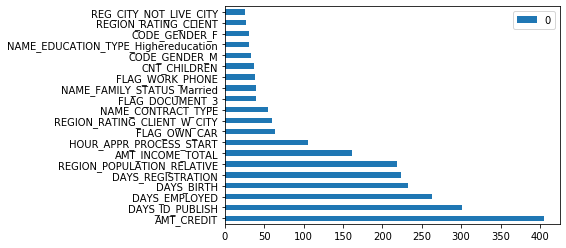

In [38]:
lgb1_importance = pd.DataFrame(data=lgb1.feature_importance(), index=lgb1.feature_name())
k = 20
lgb1_importance.nlargest(k, 0).plot.barh()

In [39]:
#Kaggleに提出するために推定と整形
pred = lgb1.predict(test_x1)
sample["TARGET"] = pred
sample.to_csv("submit_del_nan_features.csv", index=None)

**結果**

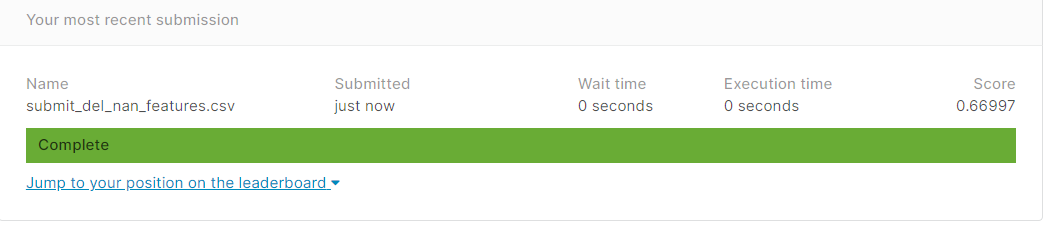

決して良いスコアとはいえない。。。

#### 欠損列を残したまま全ての特徴量を用いて学習・推定を行う

In [40]:
#まずは事前処理したデータセットをコピー
train_x2 = train_x.copy()
train_y2 = train_y.copy()
test_x2 = test_x.copy()

#行列の数を確認
print(train_x2.shape)
print(test_x2.shape)

(307511, 120)
(48744, 120)


In [41]:
le = LabelEncoder()
le_count = 0

for col in train_x2:
    if train_x2[col].dtype == 'object':
        # フィーチャー数が２以上のものはラベルエンコーディング
        if len(list(train_x2[col].unique())) <= 2:
            # 訓練データをつかって学習
            le.fit(train_x2[col])
            # 訓練データとテストデータを変換
            train_x2[col] = le.transform(train_x2[col])
            test_x2[col] = le.transform(test_x2[col])
            
            # ラベルエンコーディングしたカウントを保持
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

# 他のカテゴリ変数についてはホットエンコーディング処理
train_x2 = pd.get_dummies(train_x2)
test_x2 = pd.get_dummies(test_x2)

print('Training Features shape: ', train_x2.shape)
print('Testing Features shape: ', test_x2.shape)

3 columns were label encoded.
Training Features shape:  (307511, 241)
Testing Features shape:  (48744, 238)


In [42]:
#列数を少ない方に合わせる
train_x2, test_x2 = train_x2.align(test_x2, join="inner", axis=1)

print('Training Features shape: ', train_x2.shape)
print('Testing Features shape: ', test_x2.shape)

Training Features shape:  (307511, 238)
Testing Features shape:  (48744, 238)


In [53]:
X2_train, X2_test, y2_train, y2_test = train_test_split(train_x2, train_y2, random_state=1)
scores = []

kf = KFold(n_splits=4, shuffle=True, random_state=1)
for tr_idx, va_idx in kf.split(X2_train):
    tr_x2, va_x2 = X2_train.iloc[tr_idx], X2_train.iloc[va_idx]
    tr_y2, va_y2 = y2_train.iloc[tr_idx], y2_train.iloc[va_idx]

    tr_x2 = tr_x2.rename(columns= lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
    va_x2 = va_x2.rename(columns= lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
    
    lgb2_train = lgb.Dataset(tr_x2, tr_y2)
    num_round = 100

    params = {"objective": "binary", "seed": 1, "metrics": "auc"}
    lgb2 = lgb.train(params, lgb2_train, num_boost_round=num_round)
    
    pred = lgb2.predict(va_x2)
    score = roc_auc_score(va_y2, pred)
    scores.append(score)

print(scores)
print(sum(scores) / len(scores))


[0.7530690021679505, 0.7602015945285586, 0.7499008816114492, 0.7491412070566155]
0.7530781713411434


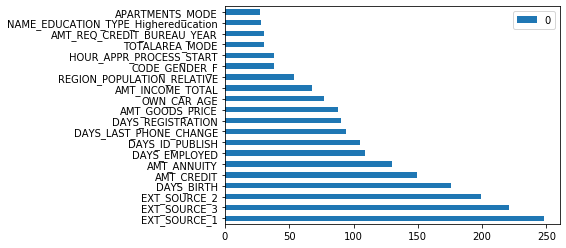

In [44]:
#重要度トップ２０を確認してみる
lgb2_importance = pd.DataFrame(data=lgb2.feature_importance(),
                               index=lgb2.feature_name()).sort_values(by=0, ascending=False)

k = 20
lgb2_importance.nlargest(k, 0).plot.barh()

In [45]:
#テストデータに対して推定とKaggle提出
pred = lgb2.predict(test_x2)
sample["TARGET"] = pred
sample.to_csv("submit_all_features.csv", index=None)

**結果**

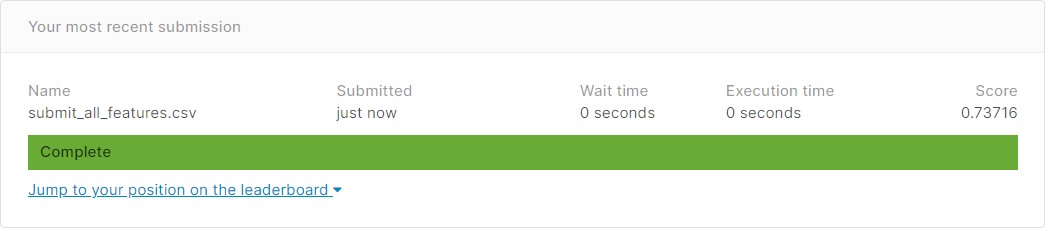

欠損列をすべて削除する手法より精度が高かった。  
欠損が含まれる列には、ターゲットを予測するには重要度の高い特徴が存在することが言える  
前回、学習に使う特徴から外した「EXT_SOURCE_X」が非常に有効な特徴であった。


#### 重要度の高い上位20個の特徴で学習・推定を行う

In [46]:
#まずは事前処理したデータセットをコピー
train_x3 = train_x.copy()
train_y3 = train_y.copy()
test_x3 = test_x.copy()


In [47]:
#重要度の高い上位２０特徴を選択
k = 20
conv_dict = {"NAME_EDUCATION_TYPE_Highereducation":"NAME_EDUCATION_TYPE", "CODE_GENDER_F":"CODE_GENDER"}

important_feats = lgb2_importance.nlargest(k, 0).rename(index=conv_dict).index
train_x3 = train_x3[important_feats]
test_x3 = test_x3[important_feats]

print(train_x3.shape)
print(test_x3.shape)

(307511, 20)
(48744, 20)


In [48]:
le = LabelEncoder()
le_count = 0

for col in train_x3:
    if train_x3[col].dtype == 'object':
        # フィーチャー数が２以上のものはラベルエンコーディング
        if len(list(train_x3[col].unique())) <= 2:
            # 訓練データをつかって学習
            le.fit(train_x3[col])
            # 訓練データとテストデータを変換
            train_x3[col] = le.transform(train_x3[col])
            test_x3[col] = le.transform(test_x3[col])
            
            # ラベルエンコーディングしたカウントを保持
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

# 他のカテゴリ変数についてはホットエンコーディング処理
train_x3 = pd.get_dummies(train_x3)
test_x3 = pd.get_dummies(test_x3)

print('Training Features shape: ', train_x3.shape)
print('Testing Features shape: ', test_x3.shape)

0 columns were label encoded.
Training Features shape:  (307511, 26)
Testing Features shape:  (48744, 25)


In [49]:
train_x3, test_x3 = train_x3.align(test_x3, join="inner", axis=1)

print('Training Features shape: ', train_x3.shape)
print('Testing Features shape: ', test_x3.shape)

Training Features shape:  (307511, 25)
Testing Features shape:  (48744, 25)


In [50]:
X3_train, X3_test, y3_train, y3_test = train_test_split(train_x3, train_y3, random_state=1)
scores = []

kf = KFold(n_splits=4, shuffle=True, random_state=1)
for tr_idx, va_idx in kf.split(X3_train):
    tr_x3, va_x3 = X3_train.iloc[tr_idx], X3_train.iloc[va_idx]
    tr_y3, va_y3 = y3_train.iloc[tr_idx], y3_train.iloc[va_idx]

    tr_x3 = tr_x3.rename(columns= lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
    va_x3 = va_x3.rename(columns= lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
    
    lgb3_train = lgb.Dataset(tr_x3, tr_y3)
    num_round = 100

    params = {"objective": "binary", "seed": 1, "metrics": "binary-logless"}
    lgb3 = lgb.train(params, lgb3_train, num_boost_round=num_round)
    
    pred = lgb3.predict(va_x3)
    score = roc_auc_score(va_y3, pred)
    scores.append(score)

print(scores)
print(sum(scores) / len(scores))

[0.7513506187066641, 0.7578688077200005, 0.7475489966271603, 0.7461224210676055]
0.7507227110303576


In [51]:
#テストデータに対して推定とKaggle提出
pred = lgb3.predict(test_x3)
sample["TARGET"] = pred
sample.to_csv("submit_only_important_features.csv", index=None)

**結果**

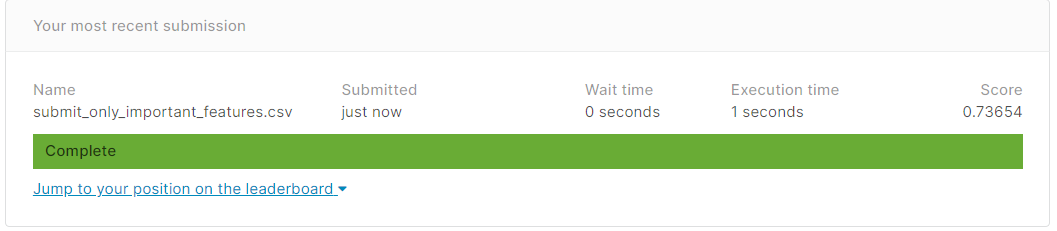

特徴量を重要度の高いものだけに減らした場合、少し精度が落ちた。  

#### 既存の特徴量を加工して学習・推定を行う（DAYS_EMPLOYEDの加工）

In [52]:
#まずは事前処理したデータセットをコピー
train_x4 = train_x.copy()
train_y4 = train_y.copy()
test_x4 = test_x.copy()

In [61]:
train_x4["DAYS_EMPLOYED"] = train_x4["DAYS_EMPLOYED"].replace({365243:np.nan})

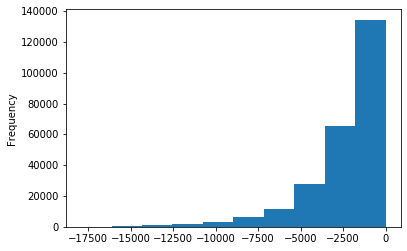

In [62]:
train_x4["DAYS_EMPLOYED"].plot.hist()

In [63]:
le = LabelEncoder()
le_count = 0

for col in train_x4:
    if train_x4[col].dtype == 'object':
        # フィーチャー数が２以上のものはラベルエンコーディング
        if len(list(train_x4[col].unique())) <= 2:
            # 訓練データをつかって学習
            le.fit(train_x4[col])
            # 訓練データとテストデータを変換
            train_x4[col] = le.transform(train_x4[col])
            test_x4[col] = le.transform(test_x4[col])
            
            # ラベルエンコーディングしたカウントを保持
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

# 他のカテゴリ変数についてはホットエンコーディング処理
train_x4 = pd.get_dummies(train_x4)
test_x4 = pd.get_dummies(test_x4)

print('Training Features shape: ', train_x4.shape)
print('Testing Features shape: ', test_x4.shape)

3 columns were label encoded.
Training Features shape:  (307511, 241)
Testing Features shape:  (48744, 238)


In [65]:
train_x4, test_x4 = train_x4.align(test_x4, join="inner", axis=1)

print('Training Features shape: ', train_x4.shape)
print('Testing Features shape: ', test_x4.shape)

Training Features shape:  (307511, 238)
Testing Features shape:  (48744, 238)


In [66]:
X4_train, X4_test, y4_train, y4_test = train_test_split(train_x4, train_y4, random_state=1)
scores = []

kf = KFold(n_splits=4, shuffle=True, random_state=1)
for tr_idx, va_idx in kf.split(X4_train):
    tr_x4, va_x4 = X4_train.iloc[tr_idx], X4_train.iloc[va_idx]
    tr_y4, va_y4 = y4_train.iloc[tr_idx], y4_train.iloc[va_idx]

    tr_x4 = tr_x4.rename(columns= lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
    va_x4 = va_x4.rename(columns= lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
    
    lgb4_train = lgb.Dataset(tr_x4, tr_y4)
    num_round = 100

    params = {"objective": "binary", "seed": 1, "metrics": "auc"}
    lgb4 = lgb.train(params, lgb4_train, num_boost_round=num_round)
    
    pred = lgb4.predict(va_x4)
    score = roc_auc_score(va_y4, pred)
    scores.append(score)

print(scores)
print(sum(scores) / len(scores))

[0.7518247044105665, 0.760712051885396, 0.7494924080854066, 0.749290345971187]
0.752829877588139


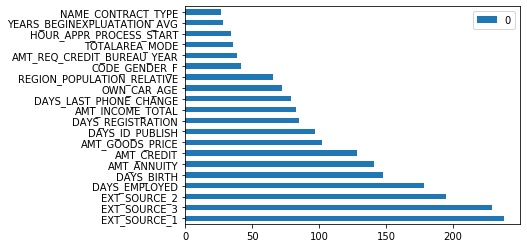

In [68]:
#重要度トップ２０を確認してみる
lgb4_importance = pd.DataFrame(data=lgb4.feature_importance(),
                               index=lgb4.feature_name()).sort_values(by=0, ascending=False)

k = 20
lgb4_importance.nlargest(k, 0).plot.barh()

In [69]:
#テストデータに対して推定とKaggle提出
pred = lgb4.predict(test_x4)
sample["TARGET"] = pred
sample.to_csv("submit_processing_days-employ_features.csv", index=None)

**結果**

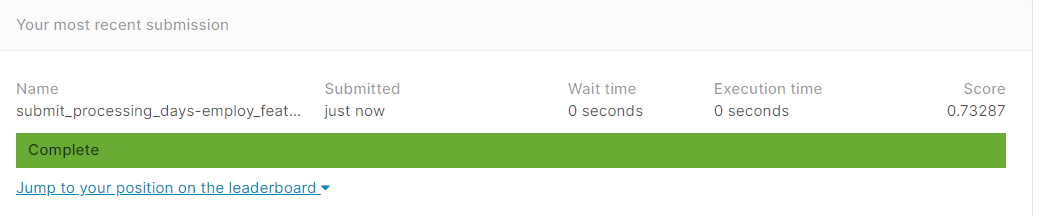

加工処理を行ったことで重要度も高い値になっているのに、予測精度はさがってしまった。。  
理由がわからない。。。

(5, 0)

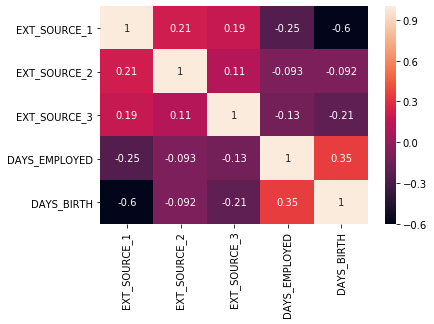

In [73]:
cols = ["EXT_SOURCE_1", "EXT_SOURCE_2", "EXT_SOURCE_3", "DAYS_EMPLOYED", "DAYS_BIRTH"]
sns.heatmap(train_x4[cols].corr(), annot=True)
plt.ylim(len(train_x4[cols].corr()), 0)

#### 新しい特徴量を追加して学習・推定を行う

In [74]:
#まずは事前処理したデータセットをコピー
train_x5 = train_x.copy()
train_y5 = train_y.copy()
test_x5 = test_x.copy()

train_x5["DAYS_EMPLOYED"] = train_x5["DAYS_EMPLOYED"].replace({365243:np.nan})

* 収入に対する年金の割合を特徴量として作成
* 収入に対する借入額を特徴量として作成
* 家族１人あたりの年収

In [80]:
#新たな特徴量を作成
train_x5["ANNUITY_PER_INCOME"] = train_x5["AMT_ANNUITY"] / train_x5["AMT_INCOME_TOTAL"]
train_x5["CREDIT_PER_INCOME"] = train_x5["AMT_CREDIT"] / train_x5["AMT_INCOME_TOTAL"]
train_x5["INCOME_PER_FAMILY"] = train_x5["AMT_INCOME_TOTAL"] / train_x5["CNT_FAM_MEMBERS"]

test_x5["ANNUITY_PER_INCOME"] = test_x5["AMT_ANNUITY"] / test_x5["AMT_INCOME_TOTAL"]
test_x5["CREDIT_PER_INCOME"] = test_x5["AMT_CREDIT"] / test_x5["AMT_INCOME_TOTAL"]
test_x5["INCOME_PER_FAMILY"] = test_x5["AMT_INCOME_TOTAL"] / test_x5["CNT_FAM_MEMBERS"]

In [81]:
le = LabelEncoder()
le_count = 0

for col in train_x5:
    if train_x5[col].dtype == 'object':
        # フィーチャー数が２以上のものはラベルエンコーディング
        if len(list(train_x5[col].unique())) <= 2:
            # 訓練データをつかって学習
            le.fit(train_x5[col])
            # 訓練データとテストデータを変換
            train_x5[col] = le.transform(train_x5[col])
            test_x5[col] = le.transform(test_x5[col])
            
            # ラベルエンコーディングしたカウントを保持
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

# 他のカテゴリ変数についてはホットエンコーディング処理
train_x5 = pd.get_dummies(train_x5)
test_x5 = pd.get_dummies(test_x5)

print('Training Features shape: ', train_x5.shape)
print('Testing Features shape: ', test_x5.shape)

0 columns were label encoded.
Training Features shape:  (307511, 241)
Testing Features shape:  (48744, 241)


In [82]:
train_x5, test_x5 = train_x5.align(test_x5, join="inner", axis=1)

print('Training Features shape: ', train_x5.shape)
print('Testing Features shape: ', test_x5.shape)

Training Features shape:  (307511, 241)
Testing Features shape:  (48744, 241)


In [86]:
X5_train, X5_test, y5_train, y5_test = train_test_split(train_x5, train_y5, random_state=1)
scores = []

kf = KFold(n_splits=5, shuffle=True, random_state=1)
for tr_idx, va_idx in kf.split(X5_train):
    tr_x5, va_x5 = X5_train.iloc[tr_idx], X5_train.iloc[va_idx]
    tr_y5, va_y5 = y5_train.iloc[tr_idx], y5_train.iloc[va_idx]

    tr_x5 = tr_x5.rename(columns= lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
    va_x5 = va_x5.rename(columns= lambda x:re.sub("[^A-Za-z0-9_]+", "", x))
    
    lgb5_train = lgb.Dataset(tr_x5, tr_y5)
    num_round = 100

    params = {"objective": "binary", "seed": 1, "metrics": "auc"}
    lgb5 = lgb.train(params, lgb5_train, num_boost_round=num_round)
    
    pred = lgb5.predict(va_x5)
    score = roc_auc_score(va_y5, pred)
    scores.append(score)

print(scores)
print(sum(scores) / len(scores))

[0.754301502611806, 0.7566581417368841, 0.7552294479116045, 0.7552533968592237, 0.7496233733001663]
0.754213172483937


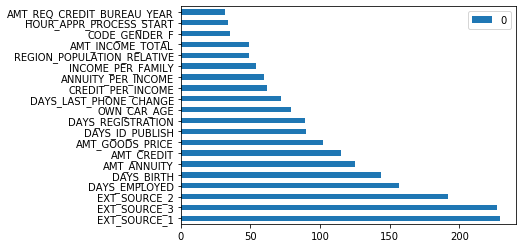

In [84]:
#重要度トップ２０を確認してみる
lgb5_importance = pd.DataFrame(data=lgb5.feature_importance(),
                               index=lgb5.feature_name()).sort_values(by=0, ascending=False)

k = 20
lgb5_importance.nlargest(k, 0).plot.barh()

In [87]:
#テストデータに対して推定とKaggle提出
pred = lgb5.predict(test_x5)
sample["TARGET"] = pred
sample.to_csv("submit_add_features.csv", index=None)

**結果**

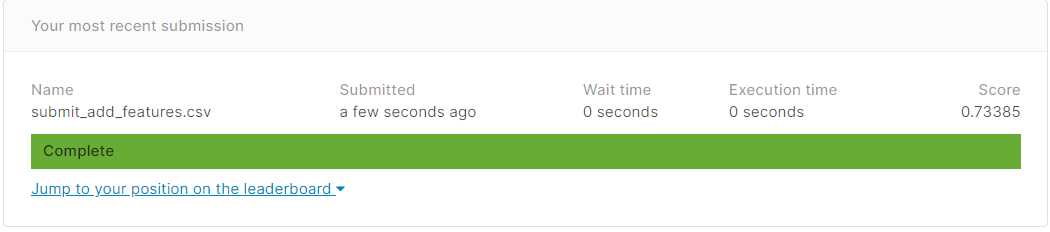

検証では一番精度が高かったが、Kaggleに提出してみるとそれほど良い結果は得られかった  
過学習を起こしたのか。。。

### まとめ


<<実践パターン>>
1. 欠損のある列をすべて削除し、残りの全ての特徴量を用いて学習・推定を行う  
2. 欠損列を残したまま全ての特徴量を用いて学習・推定を行う
3. 2.のモデルで算出された重要度の高い上位20個の特徴で学習・推定を行う
4. 既存の特徴量を加工して学習・推定を行う（DAYS_EMPLOYEDの加工）
5. 新しい特徴量を追加して学習・推定を行う

<<結果>>

2 > 3 > 5 > 4 > 1  の順番に良い結果が得られた

<<今回分かったこと>>
* 1と2の結果を比較して、欠損が多く含まれる列でも重要な特徴が含まれることが分かった
* 2と3の結果を比較して、重要な特徴を選択して学習すれば、全ての特徴量を使った場合に比べ精度にそれほど差はない
* 3と4の結果を比較して、異常値を正したからといってモデル全体の精度が高くなるとは限らない
* 4と5の結果を比較して、新たな特徴量を追加しても必ず精度が上がるとは限らない

多重共線性の影響？